In [1]:
import pandas as pd
from collections import defaultdict
import operator
from collections import Counter
import string
import numpy as np
import sys
from scipy.stats import pearsonr 
import pylab 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy import dot
from numpy.linalg import norm
import sklearn.metrics.pairwise
from statistics import mean, stdev
import math

In [8]:
partition = defaultdict(lambda:[])
skillset = []
sp = {}
with open('/Users/ditong/Documents/skillProject/description/data/SOC/partition_0.0_0.0_6_0.51.txt','r') as f:
    for line in f:
        skill = line.split('\t')[0]
        skillset.append(skill)
        group = int(line.split('\t')[1])
        partition[group].append(skill)
        sp[skill] = group

In [3]:
len(partition),len(sp)

(6, 10296)

In [2]:
# year job skill frequency
ysjf = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Documents/skillProject/description/data/SOC/occ_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            for skill_freq in skills:
                skill = skill_freq.split('_')[0].lower()
                freq = int(skill_freq.split('_')[1])
                ysjf[year][skill][job] = freq

In [3]:
# read in the rca score for each skill for each occupation
syorca = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
syopmi = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Documents/skillProject/description/data/SOC/occ_skill_rca.txt', 'r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        occ = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        for s_rca in skills:
            skill = s_rca.split('_')[0].lower()
            rca = float(s_rca.split('_')[1])
            syorca[skill][year][occ] = rca
            syopmi[skill][year][occ] = math.log(rca)

In [4]:
syloc = defaultdict(lambda:defaultdict(lambda:''))
ysloc = defaultdict(lambda:defaultdict(lambda:''))
for skill in syopmi:
    for year in range(2010,2019):
        if skill in ysjf[year]:
            s=sum(ysjf[year][skill].values())
            jp = dict((k,v/s) for k,v in ysjf[year][skill].items())
            score =sum(jp[occ]*syopmi[skill][year][occ] for occ in syopmi[skill][year])
            syloc[skill][year] = score
            ysloc[year][skill] = score

In [5]:
sypmi = defaultdict(lambda:defaultdict(lambda:0))
yspmi = defaultdict(lambda:defaultdict(lambda:0))
for skill in syopmi:
    for year in syopmi[skill]:
        sypmi[skill][year] = mean(syopmi[skill][year].values())
        yspmi[year][skill] = mean(syopmi[skill][year].values())

In [10]:
list(sorted([(mean(v.values()), k) for k,v in syloc.items()]))[-10:]

[(10.279836793419939, 'chiropractic diagnosis'),
 (10.498786756908144, 'biopsy diagnosis'),
 (10.618023172828977, 'biomass fuel gasification systems'),
 (11.052145728826387, 'miner operator'),
 (11.073106959720812, 'molecular biology of cancer cells'),
 (11.109580782789022, 'musculoskeletal system correction'),
 (11.393319245043635, 'pex soldering'),
 (11.412786842103037, 'power thinning saws'),
 (11.974131497303636, 'stroke delimbers'),
 (12.351393769871462, 'quarrying methods')]

In [36]:
list(sorted([(mean(v.values()), k) for k,v in syloc.items()]))[:10]

[(0.046465839687876515, 'communication skills'),
 (0.07659452976696385, 'teamwork / collaboration'),
 (0.08563559144101997, 'problem solving'),
 (0.09188677949586527, 'written communication'),
 (0.12942329471610037, 'verbal / oral communication'),
 (0.14865023938503028, 'organizational skills'),
 (0.16112572459511973, 'writing'),
 (0.16796595879028817, 'time management'),
 (0.18525524261765575, 'planning'),
 (0.1920570063367778, 'prioritizing tasks')]

In [6]:
sdr = defaultdict(lambda:defaultdict(lambda:0))
for skill in syloc:
    if 2018 in syloc[skill] and 2010 in syloc[skill]:
        dr = syloc[skill][2018] - syloc[skill][2010]
        sdr[skill] = dr
sdr = dict(sorted(sdr.items(), key=operator.itemgetter(1)))

In [18]:
list(sdr.items())[:10]

[('amnesia', -8.032983293452862),
 ('herniation', -7.610265218604008),
 ('mini cad', -7.288268375376505),
 ('musculoskeletal system disorders', -7.037464616287878),
 ('gselector', -6.9603226404229375),
 ('backing maneuvers', -6.340260540643247),
 ('play framework', -6.00338466916336),
 ('farm product marketing', -5.969486141624404),
 ('union election', -5.715294574958942),
 ('issuing store credit', -5.528667195180471)]

In [19]:
sorted(sdr.items(), key=operator.itemgetter(1), reverse=True)[:10]

[('lipitor', 7.9334986410015755),
 ('oracle cards', 7.047230392695633),
 ('biomass research', 6.764722038442161),
 ('procedure demonstration', 6.245525925393315),
 ('oil mining', 5.833806454135165),
 ('menorrhagia', 5.827950621769108),
 ('petroleum extraction', 5.654940771529436),
 ('boat deploying', 5.4059793481452605),
 ('geochemical surveys', 5.265602510541508),
 ('hair styling', 5.156252035069388)]

In [29]:
syloc['python'][2010], syloc['python'][2018]

(0.8003155627938159, 1.291085189500556)

In [12]:
pysloc= defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:'')))
psyloc = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:'')))
for g in partition:
    for skill in partition[g]:
        if skill in syloc:
            for year in syloc[skill]:
                pysloc[g][year][skill] = syloc[skill][year]  
                psyloc[g][skill][year] = syloc[skill][year]

In [13]:
pyloc = defaultdict(lambda:defaultdict(lambda:0))
for g in partition:
    for year in pysloc[g]:
        if year != 2019:
            pyloc[g][year] = mean(pysloc[g][year].values())

In [10]:
yfsloc = defaultdict(lambda:defaultdict(lambda:0))
for year in range(2010,2019):
    for skill in ysloc[year]:
        if skill in skillset:
            yfsloc[year][skill] = ysloc[year][skill]

In [11]:
yloc = {}
for year in range(2010,2019):
    yloc[year] = mean(yfsloc[year].values())

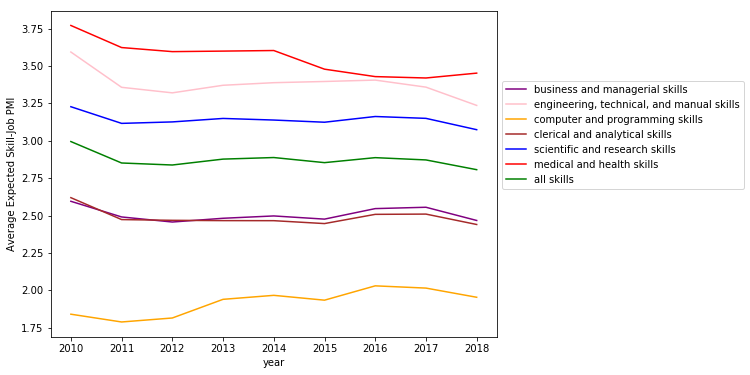

In [14]:
color = ['purple', 'pink', 'orange', 'brown', 'blue', 'red', 'green']
labels = ['business and managerial skills', 'engineering, technical, and manual skills', 
          'computer and programming skills', 'clerical and analytical skills', 
          'scientific and research skills', 'medical and health skills']
fig, ax = plt.subplots(figsize = (8,6))
for g in pyloc:
    x,y=zip(*pyloc[g].items())
    plt.plot(x, y, color=color[g], label=labels[g])
    
x,y=zip(*yloc.items())
plt.plot(x, y, color=color[6], label='all skills')
plt.xlabel('year')
plt.ylabel('Average Expected Skill-Job PMI')
plt.legend(bbox_to_anchor=(1.0, 0.8))
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/SkillJobPmiChange.png", bbox_inches='tight')

In [39]:
pysloc= defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:'')))
psyloc = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:'')))
for g in partition:
    for skill in partition[g]:
        if skill in syloc:
            for year in syloc[skill]:
                pysloc[g][year][skill] = syloc[skill][year]  
                psyloc[g][skill][year] = syloc[skill][year]  

In [40]:
psdr = defaultdict(lambda:defaultdict(lambda:0))
for g in psyloc:
    for skill in psyloc[g]:
        if 2018 in syloc[skill] and 2010 in syloc[skill]:
            dr = psyloc[g][skill][2018] - psyloc[g][skill][2010]
            psdr[g][skill] = dr
    psdr[g] = dict(sorted(psdr[g].items(), key=operator.itemgetter(1)))

In [47]:
list(psdr[2].items())[:10]

[('metal detector monitoring', -4.893955363616522),
 ('passenger screening', -4.562299691683439),
 ('surveyor assistance', -4.2233414108921),
 ('physical ability assessment', -3.907854163323994),
 ('crop processes', -3.763828773693066),
 ('appliance construction', -2.797199695819623),
 ('sf-86', -2.7012785333517435),
 ('sailpoint identity and access management', -2.4287430673273986),
 ('pat-down searches', -2.30403238014108),
 ('titus (software)', -2.237133006508115)]

In [48]:
list(psdr[2].items())[-10:]

[('activex', 1.948846007406),
 ('base station system (bss)', 2.0168179251323792),
 ('home energy rating', 2.0910349095631076),
 ('biological warfare', 2.241463476232576),
 ('netware 6', 2.255337890336995),
 ('tibco businessevents', 2.260486285475401),
 ('silicon graphics', 2.3688012930367384),
 ('ibm servers', 2.4965756147495375),
 ('security x-ray operation', 3.021954162134972),
 ('dendrite', 3.254642712875574)]

In [43]:
list(psdr[5].items())[:10]

[('herniation', -7.610265218604008),
 ('musculoskeletal system disorders', -7.037464616287878),
 ('lasix', -4.67308543015972),
 ('diagnostic endoscopic procedures', -3.884725836625515),
 ('appliance fitting', -3.808747532266401),
 ('gynecologic disorders', -3.2630105047598974),
 ('mannitol', -3.2328901993307886),
 ('maintenance therapy', -2.911608104563081),
 ('aortic stenosis', -2.859075033018376),
 ('heartworm', -2.819970510694209)]

In [44]:
list(psdr[5].items())[-10:]

[('salon industry knowledge', 2.114021022562763),
 ('psychosocial/psychiatry', 2.151166990703764),
 ('ingenix', 2.2277818850886106),
 ('nationwide health information network', 2.4357190276543834),
 ('x-ray review', 2.9057819203456052),
 ('rh factor', 2.9076549071841704),
 ('biotechnological product marketing', 2.990471165468676),
 ('rrt & crtt', 3.269759582402435),
 ('roentgen', 3.3190865656490702),
 ('psychology/behavioral/mental health', 3.631990806129201)]